<a href="https://colab.research.google.com/github/hafsaAit/TIME-SERIES-MODELS/blob/main/Models_(ARMA_ARIMA_SARIMAX_AUTO-ARIMA_PROPHET_SKTIME).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIME SERIES MODELS




### packages

In [1]:
!pip install pmdarima


In [ ]:
pip install sktime


In [ ]:
pip install --upgrade sktime


In [ ]:
!pip install prophet


In [ ]:
pip install --upgrade scikit-learn

In [ ]:
pip install feature_engine

In [7]:
from feature_engine.datetime import DatetimeFeatures


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from pandas import date_range
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor




### DataFrame


In [10]:
df = pd.read_excel("RAIB ET LBEN.xlsx")

print(df)
print(df.columns)


    Mois fiscal  Ventes Totales (MAD) TTC
0    01/01/2012                   1394462
1    01/01/2013                   1827957
2    01/01/2014                   1736405
3    01/01/2015                   1821170
4    01/01/2016                   1287729
..          ...                       ...
134  01/12/2018                   1510079
135  01/12/2019                   1550424
136  01/12/2020                   1790322
137  01/12/2021                   1965801
138  01/12/2022                   2308003

[139 rows x 2 columns]
Index(['Mois fiscal', 'Ventes Totales (MAD) TTC'], dtype='object')



### 'Mois fiscal' en format de datetime


In [11]:
df['Mois fiscal'] = pd.to_datetime(df['Mois fiscal'], format='%d/%m/%Y')

### indexer la colonne 'Mois fiscal'


In [12]:
df.set_index('Mois fiscal', inplace=True)

In [13]:

df = df[df.index != '2011-12-01']


In [14]:
df

,Ventes Totales (MAD) TTC
Mois fiscal,
2012-01-01,1394462
2013-01-01,1827957
2014-01-01,1736405
2015-01-01,1821170
2016-01-01,1287729
...,...
2018-12-01,1510079
2019-12-01,1550424
2020-12-01,1790322


###frequency column

In [15]:
df = df.asfreq('MS')

In [16]:
print(df)

             Ventes Totales (MAD) TTC
Mois fiscal                          
2012-01-01                    1394462
2012-02-01                    1496055
2012-03-01                    1695006
2012-04-01                    1596384
2012-05-01                    2488741
...                               ...
2023-02-01                    1587666
2023-03-01                    3331324
2023-04-01                    4029513
2023-05-01                    2916238
2023-06-01                    2325122

[138 rows x 1 columns]


In [17]:
df = df.fillna(method="ffill")

<ipython-input-17-7ae71642fbdb>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")


### Visualisation de la série temporelle

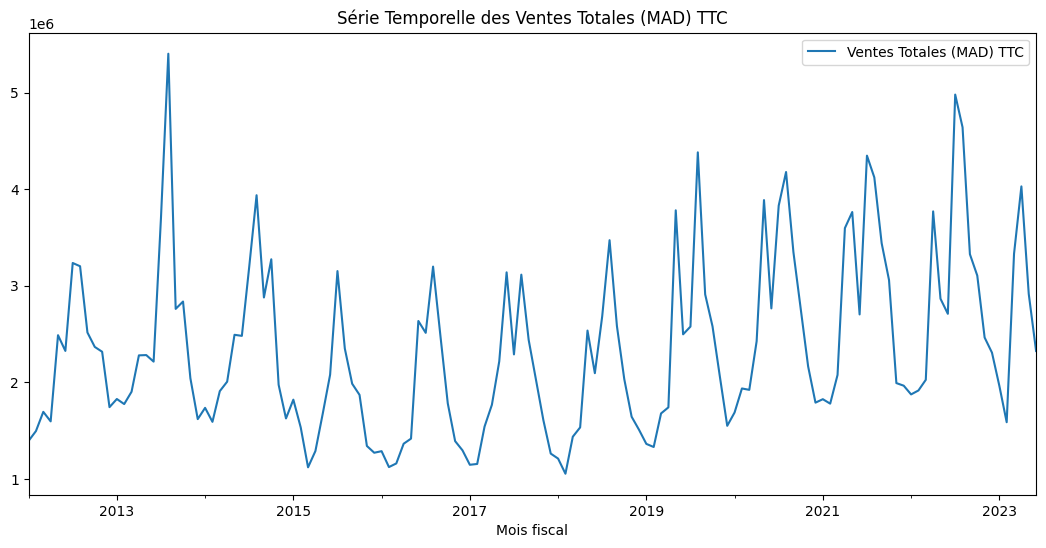

In [18]:


df.plot(y='Ventes Totales (MAD) TTC', figsize=(13, 6))
plt.title('Série Temporelle des Ventes Totales (MAD) TTC')
plt.show()


### diviser les données ( data train & data test)

In [19]:
date_fin_train = '2022-10-01'
df_train = df[df.index < date_fin_train].copy()
df_test = df[df.index >= date_fin_train].copy()


### Décompositon de la série temporelle

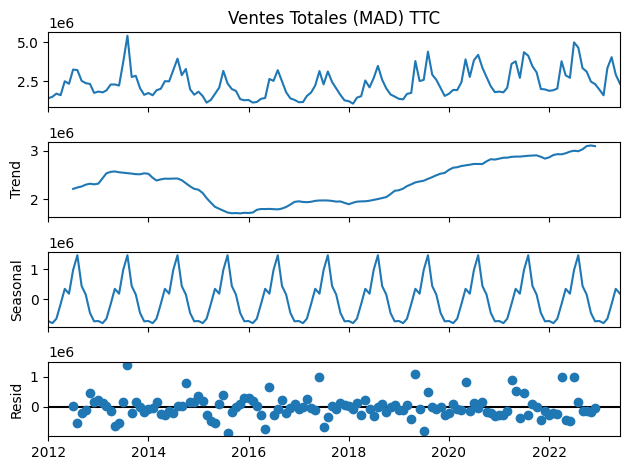

In [20]:
# @title Visualisation de ( trend & seasonality & resid)

## Extraire la série temporelle des ventes
ts = df['Ventes Totales (MAD) TTC']
# Décomposer la série temporelle
decomposition = seasonal_decompose(ts, model='additive', period=12)
# Afficher la décomposition
fig = decomposition.plot()
plt.show()


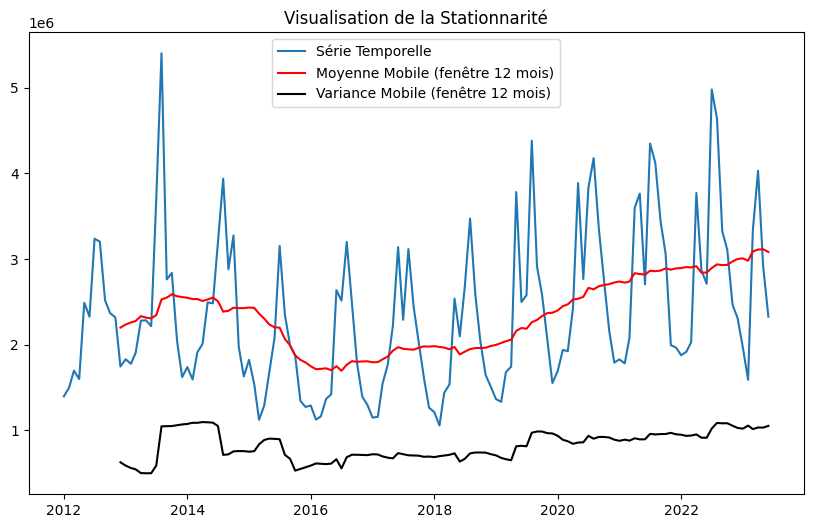

In [21]:
# @title Visualisation de la Stationnarité

ts = df['Ventes Totales (MAD) TTC']

# Vérifier s'il y a des valeurs manquantes dans la série temporelle
if ts.isnull().any():
    print("Il y a des valeurs manquantes dans la série temporelle.")
else:

    # Calculer la moyenne mobile et la variance mobile
    rolling_mean = ts.rolling(window=12).mean()
    rolling_std = ts.rolling(window=12).std()


    # Tracer la série temporelle, la moyenne mobile et la variance mobile
    plt.figure(figsize=(10, 6))
    plt.plot(ts, label='Série Temporelle')
    plt.plot(rolling_mean, color='red', label='Moyenne Mobile (fenêtre 12 mois)')
    plt.plot(rolling_std, color='black', label='Variance Mobile (fenêtre 12 mois)')
    plt.legend()
    plt.title('Visualisation de la Stationnarité')
    plt.show()


### ACF & PACF

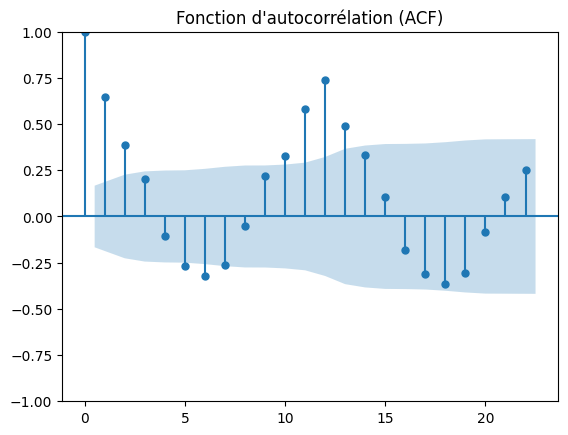

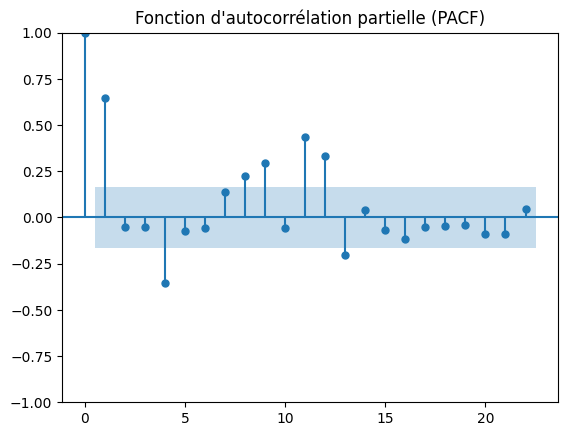

In [22]:

ts = df['Ventes Totales (MAD) TTC']

# Tracez la fonction d'autocorrélation (ACF)
plot_acf(ts)
plt.title('Fonction d\'autocorrélation (ACF)')
plt.show()

# Tracez la fonction d'autocorrélation partielle (PACF)
plot_pacf(ts)
plt.title('Fonction d\'autocorrélation partielle (PACF)')
plt.show()



### MODEL ARMA

In [36]:
# @title  MODEL AR
from statsmodels.tsa.arima.model import ARIMA

model_ar = ARIMA(ts, order=(12, 0, 0))
model_ar_fit = model_ar.fit()

print(model_ar_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                  SARIMAX Results                                   
Dep. Variable:     Ventes Totales (MAD) TTC   No. Observations:                  138
Model:                      ARIMA(12, 0, 0)   Log Likelihood               -1993.930
Date:                      Tue, 09 Apr 2024   AIC                           4015.860
Time:                              09:40:07   BIC                           4056.841
Sample:                          01-01-2012   HQIC                          4032.514
                               - 06-01-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.354e+06   5.99e+05      3.926      0.000    1.18e+06    3.53e+06
ar.L1          0.2885      0.080      3.597      0.000       0.131       0.446
ar.L

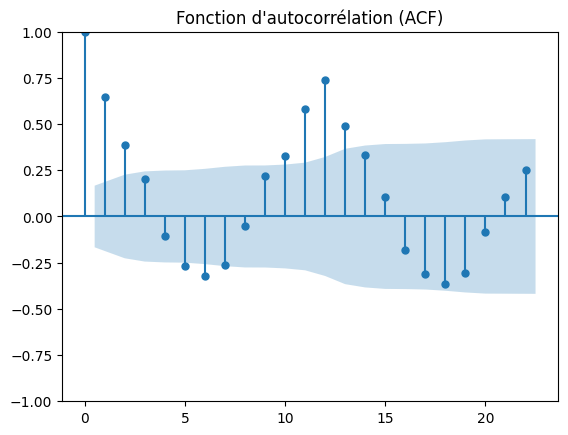

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

# Tracer la fonction d'autocorrélation (ACF)
plot_acf(ts)
plt.title('Fonction d\'autocorrélation (ACF)')
plt.show()


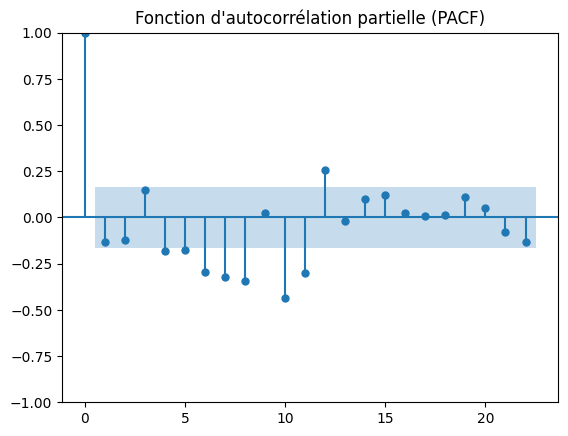

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf


plot_pacf(ts.diff().dropna())
plt.title('Fonction d\'autocorrélation partielle (PACF)')
plt.show()


In [35]:
# @title  MODEL MA
from statsmodels.tsa.arima.model import ARIMA

model_ma = ARIMA(ts, order=(0, 0, 1))
model_ma_fit = model_ma.fit()


print(model_ma_fit.summary())


                                  SARIMAX Results                                   
Dep. Variable:     Ventes Totales (MAD) TTC   No. Observations:                  138
Model:                       ARIMA(0, 0, 1)   Log Likelihood               -2056.648
Date:                      Tue, 09 Apr 2024   AIC                           4119.297
Time:                              09:39:52   BIC                           4128.078
Sample:                          01-01-2012   HQIC                          4122.865
                               - 06-01-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.354e+06   1.19e+05     19.848      0.000    2.12e+06    2.59e+06
ma.L1          0.6399      0.067      9.574      0.000       0.509       0.771
sigm

### ADF (Augmented Dickey–Fuller test)

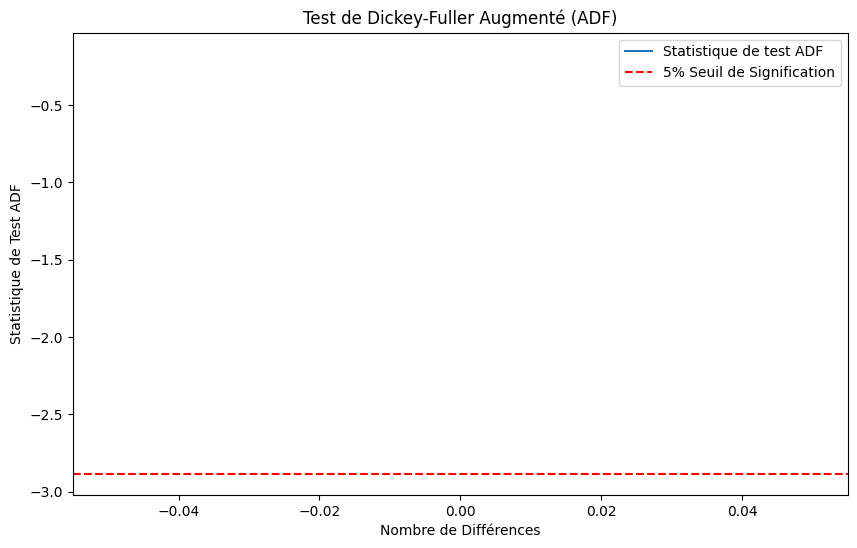

In [31]:

result = adfuller(ts)

adf_stat = result[0]

plt.figure(figsize=(10, 6))
plt.plot(result[0], label='Statistique de test ADF')
plt.axhline(y=result[4]['5%'], color='r', linestyle='--', label='5% Seuil de Signification')
plt.title('Test de Dickey-Fuller Augmenté (ADF)')
plt.xlabel('Nombre de Différences')
plt.ylabel('Statistique de Test ADF')
plt.legend()
plt.show()


In [32]:
from statsmodels.tsa.stattools import adfuller

# Effectuer le test de Dickey-Fuller augmenté (ADF)
result = adfuller(ts)

# Extraire la statistique de test et la p-valeur
adf_stat = result[0]
p_value = result[1]

# Imprimer la statistique de test et la p-valeur
print(f'Statistique de test ADF : {adf_stat}')
print(f'p-valeur : {p_value}')

# Interpréter les résultats
if p_value <= 0.05:
    print("La série temporelle est stationnaire ")
else:
    print("La série temporelle n'est pas stationnaire ")


Statistique de test ADF : -0.1675643273168868
p-valeur : 0.9422790389472365
La série temporelle n'est pas stationnaire 


### CALCULE DE PARAMETRE D

In [33]:

def optimal_determination(ts):
    d = 0
    stationary = False

    # Répéter le test de stationnarité jusqu'à ce que la série temporelle devienne stationnaire
    while not stationary:

        result = adfuller(ts)


        p_value = result[1]

        # Vérifier si la série temporelle est stationnaire (p-valeur <= 0.05)
        if p_value <= 0.05:
            stationary = True
        else:
            # Si la série temporelle n'est pas stationnaire, différencier une fois de plus
            ts = ts.diff().dropna()
            d += 1

    return d


optimal_d = optimal_determination(ts)
print("Nombre optimal de différenciations (d) :", optimal_d)


Nombre optimal de différenciations (d) : 1


### MODEL ARIMA

In [34]:
# @title  ARIMA

from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(ts, order=(12, 1, 7))
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                  SARIMAX Results                                   
Dep. Variable:     Ventes Totales (MAD) TTC   No. Observations:                  138
Model:                      ARIMA(12, 1, 7)   Log Likelihood               -1975.702
Date:                      Tue, 09 Apr 2024   AIC                           3991.405
Time:                              09:39:39   BIC                           4049.804
Sample:                          01-01-2012   HQIC                          4015.137
                               - 06-01-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0165      0.441     -0.037      0.970      -0.880       0.847
ar.L2         -0.2464      0.315     -0.783      0.434      -0.863       0.371
ar.L

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# @title Prévisions ARIMA

pred_start_date  = df_test.index[0]
pred_end_date  = df_test.index[-1]

In [38]:
print(pred_start_date)
print(pred_end_date)

2022-10-01 00:00:00
2023-06-01 00:00:00


In [39]:
pred = model_arima_fit.predict(start=pred_start_date , end=pred_end_date)

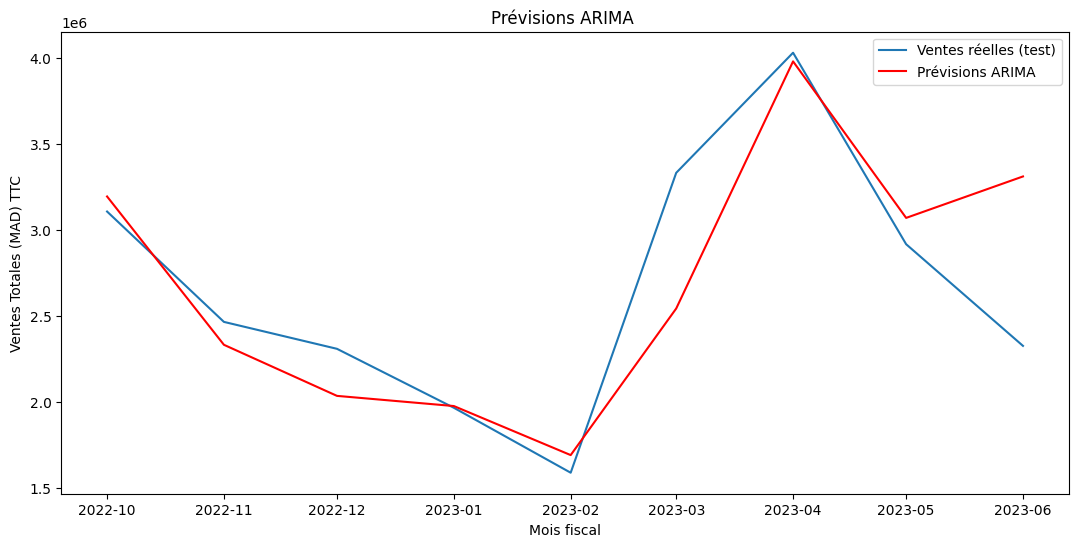

In [40]:

plt.figure(figsize=(13, 6))
plt.plot(df_test['Ventes Totales (MAD) TTC'], label='Ventes réelles (test)')
plt.plot(pred, label='Prévisions ARIMA', color='red')
plt.title('Prévisions ARIMA ')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()


### MODEL SARIMAX

In [41]:
# @title  SARIMAX


from statsmodels.tsa.statespace.sarimax import SARIMAX

# Créer le modèle SARIMAX avec des spécifications ajustées
model_sarimax = SARIMAX(ts, order=(11, 1, 6), seasonal_order=(11, 1, 6, 12))


model_sarimax_fit = model_sarimax.fit()

print(model_sarimax_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:             Ventes Totales (MAD) TTC   No. Observations:                  138
Model:             SARIMAX(11, 1, 6)x(11, 1, 6, 12)   Log Likelihood               -1799.006
Date:                              Tue, 09 Apr 2024   AIC                           3668.013
Time:                                      09:47:24   BIC                           3767.004
Sample:                                  01-01-2012   HQIC                          3708.228
                                       - 06-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5365      0.255     -2.108      0.035      -1.036      -0.038
ar.L2         -0.05

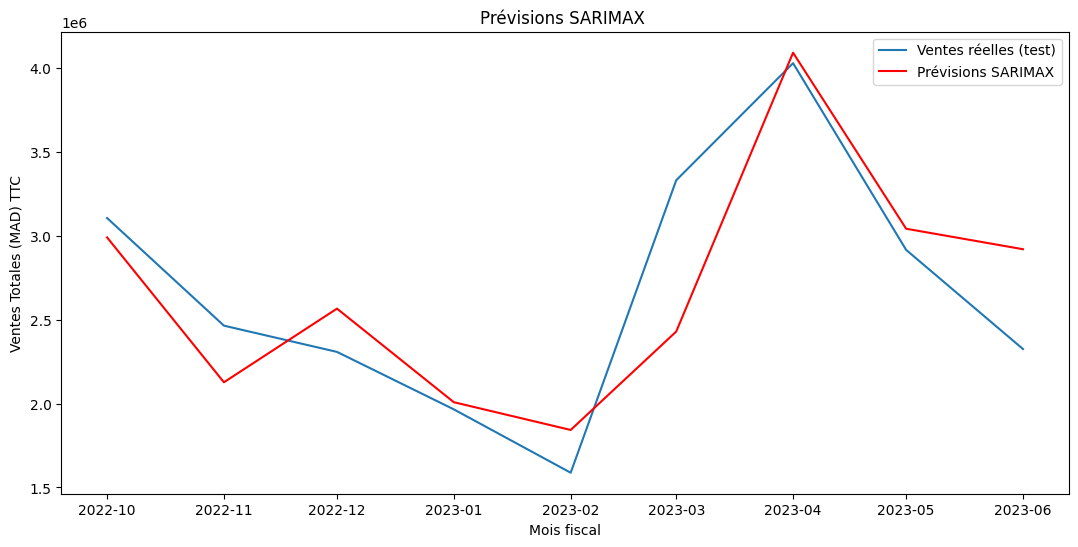

In [42]:
# @title Prévisions SARIMAX

predi_start_date  = df_test.index[0]
predi_end_date  = df_test.index[-1]

predi = model_sarimax_fit.predict(start=predi_start_date , end=predi_end_date)


plt.figure(figsize=(13, 6))
plt.plot(df_test['Ventes Totales (MAD) TTC'], label='Ventes réelles (test)')
plt.plot(predi, label='Prévisions SARIMAX', color='red')
plt.title('Prévisions SARIMAX ')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

### RMSE POUR ARMIMA & SARIMAX

In [43]:


arima_predictions = model_arima_fit.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

sarimax_predictions = model_sarimax_fit.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

# Créer une série pandas pour stocker les prédictions avec l'index de dates
arima_predictions_series = pd.Series(arima_predictions, index=df_test.index)
sarimax_predictions_series = pd.Series(sarimax_predictions, index=df_test.index)

# Calculer RMSE avec les prédictions ayant le même index que les valeurs réelles
arima_rmse = sqrt(mean_squared_error(df_test['Ventes Totales (MAD) TTC'], arima_predictions_series))
sarimax_rmse = sqrt(mean_squared_error(df_test['Ventes Totales (MAD) TTC'], sarimax_predictions_series))

arima_rmse_rounded = round(arima_rmse, 2)
sarimax_rmse_rounded = round(sarimax_rmse, 2)

print("RMSE pour ARIMA:", arima_rmse_rounded)
print("RMSE pour SARIMAX:", sarimax_rmse_rounded)

RMSE pour ARIMA: 438365.59
RMSE pour SARIMAX: 401179.45


### MODEL AUTO ARIMA

In [44]:
# @title AUTO ARIMA

from pmdarima import auto_arima

auto_arima_model = auto_arima(ts, seasonal=True, m=12, trace=True)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4098.883, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4042.257, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4052.420, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4096.897, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4098.505, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4044.255, Time=0.67 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4044.255, Time=0.37 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4052.951, Time=0.30 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4046.253, Time=0.77 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=4050.083, Time=0.23 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4038.904, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=4098.592, Time=0.21 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=4040.429, Time=1.50 sec
 ARIMA(2,1,0)(1,0,1)[12]

### MODEL PROPHET



In [45]:
# @title  PROPHET
from prophet import Prophet


model_prophet = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale=10)
model_prophet.add_seasonality(name='monthly', period=12, fourier_order=5)

df_prophet = df.reset_index().rename(columns={'Mois fiscal': 'ds', 'Ventes Totales (MAD) TTC': 'y'})


model_prophet.fit(df_prophet)



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphg3zx1tj/ajnqy5y6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphg3zx1tj/hbnca0f5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33370', 'data', 'file=/tmp/tmphg3zx1tj/ajnqy5y6.json', 'init=/tmp/tmphg3zx1tj/hbnca0f5.json', 'output', 'file=/tmp/tmphg3zx1tj/prophet_model__pacwxi/prophet_model-20240409094857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:48:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:48:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [46]:
# @title Prévisions PROPHET
predi_start_date = df_test.index[0]
predi_end_date = df_test.index[-1]


data_test = df_prophet[(df_prophet['ds'] >= predi_start_date) & (df_prophet['ds'] <= predi_end_date)]

prd = model_prophet.predict(data_test)

prd_test = prd[(prd['ds'] >= predi_start_date) & (prd['ds'] <= predi_end_date)]



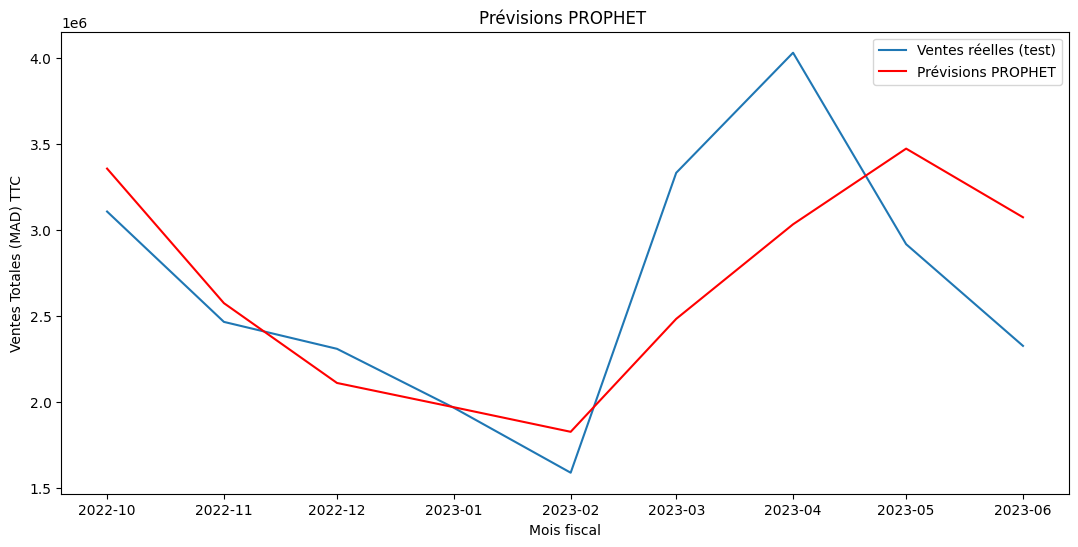

In [47]:
# @title Prévisions PROPHET
plt.figure(figsize=(13, 6))
plt.plot(df_test['Ventes Totales (MAD) TTC'], label='Ventes réelles (test)')
plt.plot(prd_test['ds'], prd_test['yhat'], label='Prévisions PROPHET', color='red')
plt.title('Prévisions PROPHET ')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

In [48]:
# @title RMSE PROPHET

merged_df = pd.merge(df_test, prd, left_on='Mois fiscal', right_on='ds', how='inner')

# Sélectionner les colonnes pertinentes pour les prédictions
prophet_predictions_series = merged_df['yhat']

# Filtrer les valeurs réelles de df_test
actual_values = merged_df['Ventes Totales (MAD) TTC']


prophet_rmse = sqrt(mean_squared_error(actual_values, prophet_predictions_series))
prophet_rmse_rounded = round(prophet_rmse, 2)

print("RMSE pour Prophet:", prophet_rmse_rounded)



RMSE pour Prophet: 553193.09


### Model Exponential Smoothing

In [49]:
# @title  Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


y_train = df_train['Ventes Totales (MAD) TTC']

prediction_model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12)


prediction_model = prediction_model.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2)




<ipython-input-49-123442d45fde>:10: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  prediction_model = prediction_model.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2)


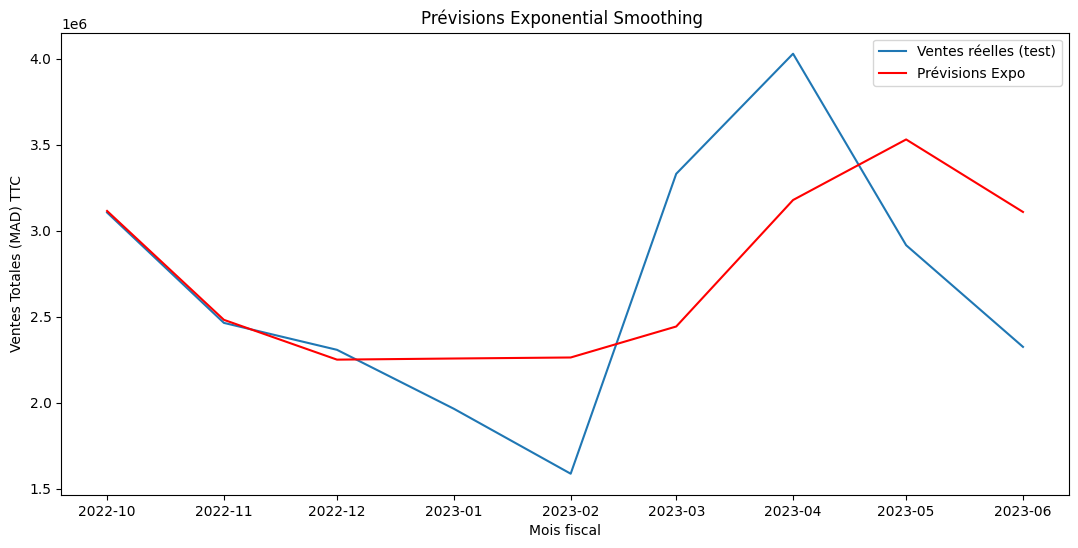

In [50]:
# @title Prévisions Exponential Smoothing
# Prévisions sur les données de test
predictions = prediction_model.predict(start='2022-10-01', end='2023-06-01')


plt.figure(figsize=(13, 6))
plt.plot(df_test['Ventes Totales (MAD) TTC'], label='Ventes réelles (test)')
plt.plot(predictions.index, predictions, label='Prévisions Expo', color='red')
plt.title('Prévisions Exponential Smoothing ')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

In [51]:
# @title RMSE Exponential Smoothing
from statsmodels.tools.eval_measures import rmse


actual_values = df_test['Ventes Totales (MAD) TTC']

expo_rmse = rmse(actual_values, predictions)
expo_rmse_rounded = round(expo_rmse, 2)

print("RMSE RMSE du modèle Exponential Smoothing:", expo_rmse_rounded)



RMSE RMSE du modèle Exponential Smoothing: 582193.46


### COMPARAISON DES MODELS

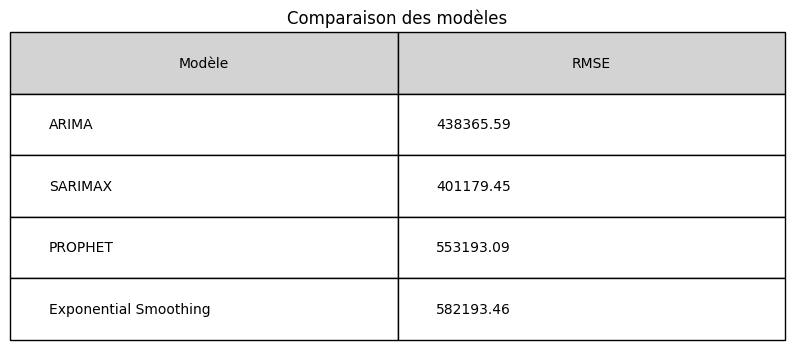


Le modèle le plus performant est: SARIMAX avec un RMSE de: 401179.45 


In [52]:

results = {
    "Modèle": ["ARIMA", "SARIMAX", "PROPHET" , "Exponential Smoothing"],
    "RMSE": [arima_rmse_rounded, sarimax_rmse_rounded, prophet_rmse_rounded , expo_rmse_rounded]
}

results_df = pd.DataFrame(results)

best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Modèle']
best_rmse = results_df['RMSE'].min()


fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
ax.set_title('Comparaison des modèles')

table = ax.table(cellText=results_df.values,
                 colLabels=results_df.columns,
                 bbox=[0, 0, 1, 1],
                 cellLoc='left',
                 colColours=['lightgrey']*len(results_df.columns))


plt.show()


print()


print("\033[1mLe modèle le plus performant est:", best_model, "avec un RMSE de:", best_rmse, "\033[0m")


### Linear Regression Model

In [53]:
df_M = df.copy()

In [54]:

df_M_train = df_train.copy()
df_M_test = df_test.copy()

In [55]:
df_M[f'moving_avg_{3}'] = df_M['Ventes Totales (MAD) TTC'].rolling(window=3).mean().shift(1)

In [58]:
df_M

,Ventes Totales (MAD) TTC,moving_avg_3,moving_avg_6
Mois fiscal,,,
2012-01-01,1394462,NaN,NaN
2012-02-01,1496055,NaN,NaN
2012-03-01,1695006,NaN,NaN
2012-04-01,1596384,1.528508e+06,NaN
2012-05-01,2488741,1.595815e+06,NaN
...,...,...,...
2023-02-01,1587666,2.245979e+06,2.968781e+06
2023-03-01,3331324,1.953678e+06,2.459838e+06
2023-04-01,4029513,2.294785e+06,2.460526e+06


In [57]:
df_M[f'moving_avg_{6}'] = df_M['Ventes Totales (MAD) TTC'].rolling(window=6).mean().shift(1)

In [59]:
df_M

,Ventes Totales (MAD) TTC,moving_avg_3,moving_avg_6
Mois fiscal,,,
2012-01-01,1394462,NaN,NaN
2012-02-01,1496055,NaN,NaN
2012-03-01,1695006,NaN,NaN
2012-04-01,1596384,1.528508e+06,NaN
2012-05-01,2488741,1.595815e+06,NaN
...,...,...,...
2023-02-01,1587666,2.245979e+06,2.968781e+06
2023-03-01,3331324,1.953678e+06,2.459838e+06
2023-04-01,4029513,2.294785e+06,2.460526e+06


In [60]:
df_M[f'moving_avg_{12}'] = df_M['Ventes Totales (MAD) TTC'].rolling(window=12).mean().shift(1)

In [61]:
df_M

,Ventes Totales (MAD) TTC,moving_avg_3,moving_avg_6,moving_avg_12
Mois fiscal,,,,
2012-01-01,1394462,NaN,NaN,NaN
2012-02-01,1496055,NaN,NaN,NaN
2012-03-01,1695006,NaN,NaN,NaN
2012-04-01,1596384,1.528508e+06,NaN,NaN
2012-05-01,2488741,1.595815e+06,NaN,NaN
...,...,...,...,...
2023-02-01,1587666,2.245979e+06,2.968781e+06,3.006888e+06
2023-03-01,3331324,1.953678e+06,2.459838e+06,2.979502e+06
2023-04-01,4029513,2.294785e+06,2.460526e+06,3.088230e+06


In [62]:
# @title Création des lag
df_M['sale_lastmonth'] = df_M['Ventes Totales (MAD) TTC'].shift(1)
df_M['sale_3Monthsback'] = df_M['Ventes Totales (MAD) TTC'].shift(3)
df_M['sale_6Monthsback'] = df_M['Ventes Totales (MAD) TTC'].shift(6)
df_M['sale_12Monthsback'] = df_M['Ventes Totales (MAD) TTC'].shift(12)

In [ ]:
# @title Codage de mois fiscal

df_M["Date"] = df.index
df_M.head()

In [64]:
df_M["year"] = df_M["Date"].dt.year
df_M["quarter"] = df_M["Date"].dt.quarter
df_M["month"] = df_M["Date"].dt.month

df_M.drop(columns="Date")

df_M.head()

,Ventes Totales (MAD) TTC,moving_avg_3,moving_avg_6,moving_avg_12,sale_lastmonth,sale_3Monthsback,sale_6Monthsback,sale_12Monthsback,Date,year,quarter,month
Mois fiscal,,,,,,,,,,,,
2012-01-01,1394462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01,2012,1,1
2012-02-01,1496055,NaN,NaN,NaN,1394462.0,NaN,NaN,NaN,2012-02-01,2012,1,2
2012-03-01,1695006,NaN,NaN,NaN,1496055.0,NaN,NaN,NaN,2012-03-01,2012,1,3
2012-04-01,1596384,1.528508e+06,NaN,NaN,1695006.0,1394462.0,NaN,NaN,2012-04-01,2012,2,4
2012-05-01,2488741,1.595815e+06,NaN,NaN,1596384.0,1496055.0,NaN,NaN,2012-05-01,2012,2,5


In [65]:
df_M.drop(columns=['Date'], inplace = True)

df_M.head()

,Ventes Totales (MAD) TTC,moving_avg_3,moving_avg_6,moving_avg_12,sale_lastmonth,sale_3Monthsback,sale_6Monthsback,sale_12Monthsback,year,quarter,month
Mois fiscal,,,,,,,,,,,
2012-01-01,1394462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,1
2012-02-01,1496055,NaN,NaN,NaN,1394462.0,NaN,NaN,NaN,2012,1,2
2012-03-01,1695006,NaN,NaN,NaN,1496055.0,NaN,NaN,NaN,2012,1,3
2012-04-01,1596384,1.528508e+06,NaN,NaN,1695006.0,1394462.0,NaN,NaN,2012,2,4
2012-05-01,2488741,1.595815e+06,NaN,NaN,1596384.0,1496055.0,NaN,NaN,2012,2,5


In [66]:
df_M.dropna(inplace=True)


In [67]:
predict_start_date = df_M_test.index[0]
predict_end_date = df_M_test.index[-1]

In [68]:
# @title Variables indépendantes et dépendantes

X_train = df_M.loc[df_M.index < predict_start_date, df_M.columns != 'Ventes Totales (MAD) TTC']
y_train = df_M.loc[df_M.index < predict_start_date, 'Ventes Totales (MAD) TTC']

X_test = df_M.loc[(df_M.index >= predict_start_date) & (df_M.index <= predict_end_date), df_M.columns != 'Ventes Totales (MAD) TTC']
y_test = df_M.loc[(df_M.index >= predict_start_date) & (df_M.index <= predict_end_date), 'Ventes Totales (MAD) TTC']


In [69]:
# @title Linear Regression
lin_model = LinearRegression()

In [70]:
lin_model.fit(X_train, y_train)


LinearRegression()

In [71]:
predictions = lin_model.predict(X_test )

In [72]:
predictions

array([3424475.89764336, 2524423.94266418, 2013584.43517046,
       2108851.87804489, 2107377.09245083, 2253221.85002746,
       3742661.6256391 , 3463290.23563452, 3414648.30413894])

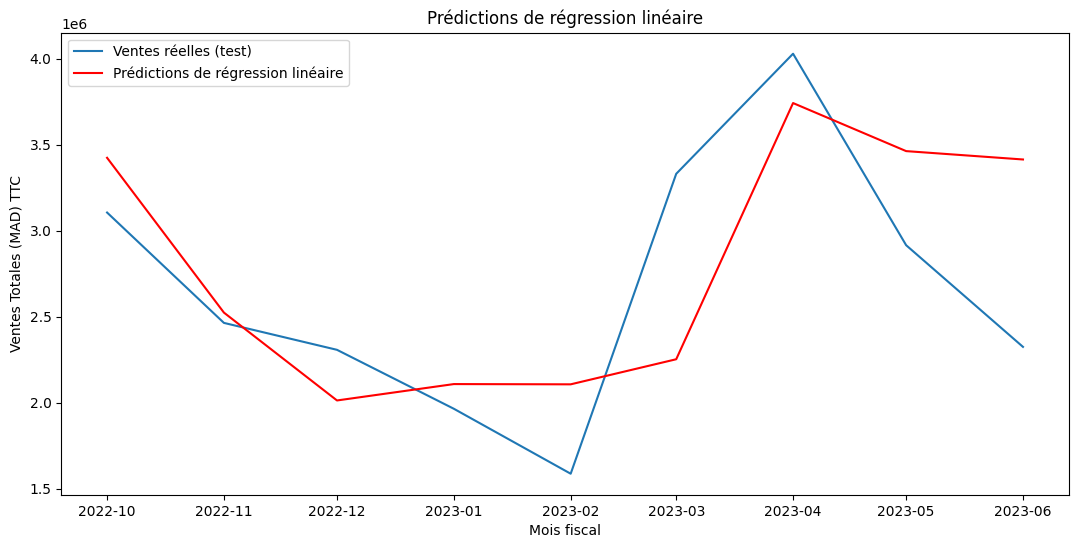

In [73]:
# @title Previsions Linear Regression
plt.figure(figsize=(13, 6))
plt.plot(y_test.index, y_test, label='Ventes réelles (test)')
plt.plot(y_test.index, predictions, label='Prédictions de régression linéaire', color='red')

plt.title('Prédictions de régression linéaire')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()


In [74]:
# @title Linear Regression RMSE
LinearRegression_rmse = mean_squared_error(y_test, predictions, squared=False)

Lin_rmse_rounded = round(LinearRegression_rmse, 2)
print(f'RMSE: {Lin_rmse_rounded}')

RMSE: 597509.37


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### RANDOM FOREST MODEL

In [76]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)


In [77]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [78]:
rf_predictions = rf_model.predict(X_test)


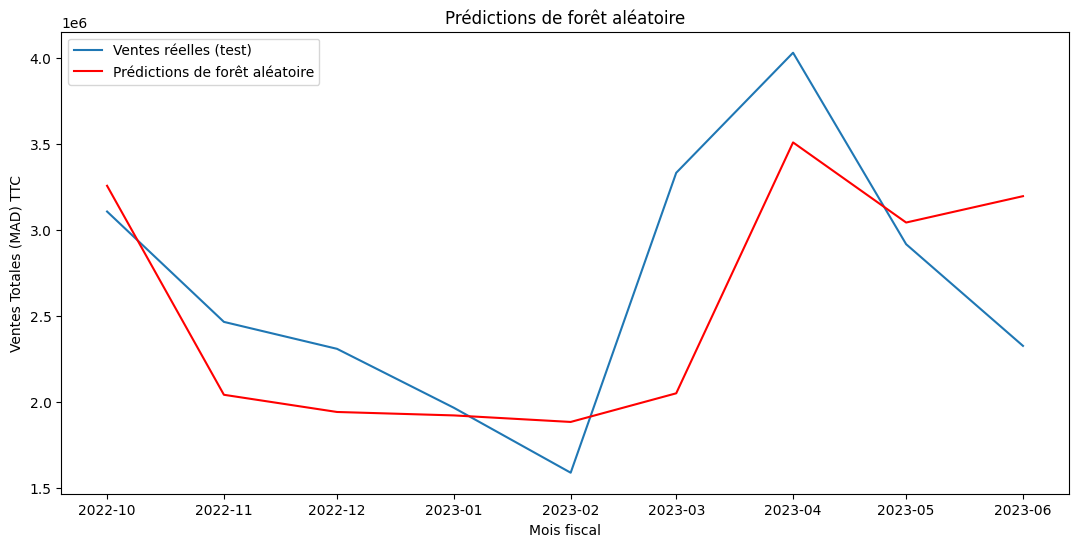

In [80]:
# @title Prévisions Random Forest
plt.figure(figsize=(13, 6))
plt.plot(y_test.index, y_test, label='Ventes réelles (test)')
plt.plot(y_test.index, rf_predictions, label='Prédictions de forêt aléatoire', color='RED')

plt.title('Prédictions de forêt aléatoire')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

In [81]:
# @title Random Forest Regression RMSE
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
rf_rmse_rounded = round(rf_rmse, 2)
print(f'RMSE pour la forêt aléatoire : {rf_rmse_rounded}')

RMSE pour la forêt aléatoire : 588288.86


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
